In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import os
## 3 
# =======================
# img_dir = "E://data_bone//3-a+b_all_正確
##
# img_dir = "E://data_bone//3-a+b_all_正確//front"
# model = tf.keras.models.load_model('D://reaserch//Bone-Fracture-Detection//weights//中榮//front//transfer_imagenet//a+b_new_data//3-a+b_all_正確_3class_frac.h5')
##
# img_dir = "E://data_bone//3-a+b_all_正確//side"
# model = tf.keras.models.load_model('D://reaserch//Bone-Fracture-Detection//weights//中榮//side//transfer_imagenet//a+b_new_data//3-a+b_all_正確_3class_frac.h5')
# =======================

## 4
# =======================
# img_dir = "E://data_bone//4-a+b_swift_cut_正確"
## 
# img_dir = "E://data_bone//4-a+b_swift_cut_正確//front"
# model = tf.keras.models.load_model('D://reaserch//Bone-Fracture-Detection//weights//中榮//front//transfer_imagenet//a+b_new_data//4-a+b_swift_cut_正確_3class_frac.h5')
##
# img_dir = "E://data_bone//4-a+b_swift_cut_正確//side"
# model = tf.keras.models.load_model('D://reaserch//Bone-Fracture-Detection//weights//中榮//side//transfer_imagenet//a+b_new_data//4-a+b_swift_cut_正確_3class_frac.h5')
# =======================

## 8-seg用 只有front
# ==========
img_dir = "E://data_bone//8 - crop_twice_正確_labelme//front"

# ==========




In [2]:
## load file
def class_3_type(root):
    label = ""
    if "正常" in root:
        label = "0"
    elif "雙踝" in root:
        label = "1"
    elif "三踝" in root:
        label = "2"
    return label

def class_2_type(root):
    label = ""
    if "正常" in root:
        label = "0"
    else:
        label = "1"
    return label

def load_path(path, class_count):
    dataset = []
    class_type = ''
    if class_count == 2:
        class_type = class_2_type
    elif class_count == 3:
        class_type = class_3_type   

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith('.jpg'):
                label = class_type(root)
                # if label != "":
                dataset.append(
                                {   
                                    'uuid': root.split("\\")[-1],
                                    'label': label,
                                    'image_path': os.path.join(root, file)
                                }
                            )

    return dataset

In [3]:
## load data and  labels
# =========================
labels = []
filepaths = []
data = load_path(img_dir, 3)
for row in data:
    labels.append(row['label'])
    filepaths.append(row['image_path'])

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)
# =========================

# cluster data

### preprocess1


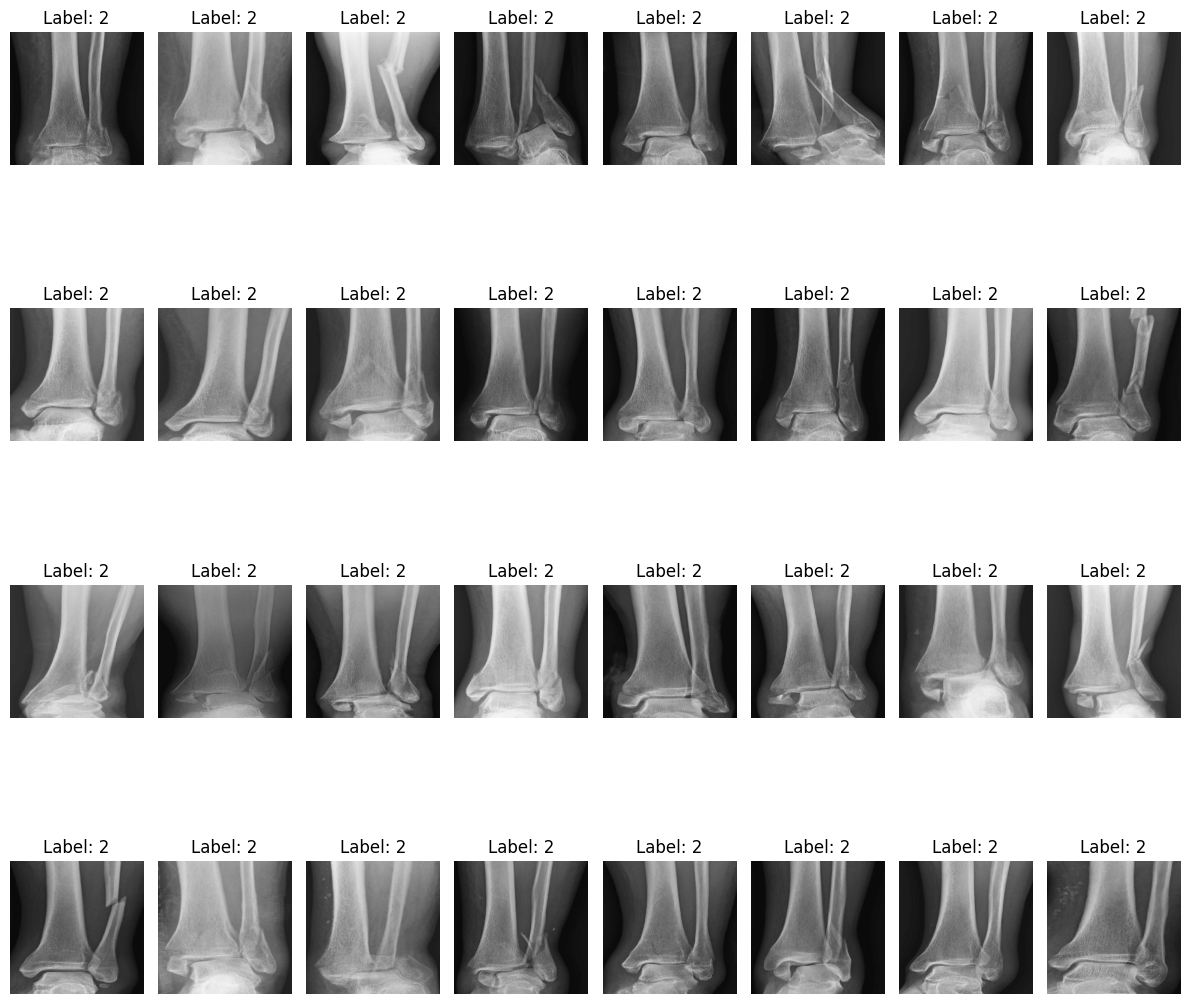

In [4]:


## 單張預處理
def preprocess_image(image_path, target_size=(224, 224)):
    # 讀取影像，調整大小
    image = load_img(image_path, target_size=target_size)
    # 轉換成 numpy array
    image_array = img_to_array(image)
    # 進行縮放
    image_array = image_array / 255
    return image_array

## 對所有影像進行預處理
# =========================
processed_images = []
for filepath in images['Filepath']:
    processed_image = preprocess_image(filepath)
    processed_images.append(processed_image)
# =========================

## 將處理後的影像轉換為 numpy array
processed_images = np.array(processed_images)

## 檢視部分預處理後的影像
plt.figure(figsize=(12, 12))
image_count = 0

for i in range(len(processed_images)):
    image = processed_images[i]  # 已經預處理的影像
    label = images['Label'].iloc[i]  # 對應的標籤

    # 將影像範圍轉換回 [0, 255]，便於顯示
    image = image * 255

    # 顯示影像
    plt.subplot(4,8, image_count + 1)  # 假設要顯示32張圖
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')

    image_count += 1

    # 停止條件，如果已經顯示了32張圖
    if image_count == 32:
        break

plt.tight_layout()
plt.show()


### preprocess2

In [ ]:
from sklearn.preprocessing import StandardScaler
from PIL import Image

def sorted_cluster(image, labels, n_clusters):
    pixel_arr = []
    range_arr = []
    for i in range(n_clusters):
        cluster_pixels = image[labels == i]
        # ==========
        ## 用平均值
        pixel_arr.append(round(np.mean(cluster_pixels)))
        
        ## 用0,1,2,3,4 
        # pixel_arr.append(min(cluster_pixels))
        # ==========
        range_arr.append(f"{min(cluster_pixels)} ~ {max(cluster_pixels)}")


    # sorted = list(np.argsort(np.argsort(pixel_arr)))
    sorted = np.argsort(pixel_arr)
    for idx, sorted_index in enumerate(sorted):
        print(f"Sorted Cluster {idx}: {range_arr[sorted_index]}")
        
    ## 用0,1,2,3,4 
    # return list(np.argsort(sorted))

    ## 用平均值
    return pixel_arr

def cluster_image(image, n_clusters=5, file_info=""):

    ## RGB
    pixel_values = image.reshape((-1, 3))
    # pixel_values = image[:,:,0].reshape((-1, 1))

    # 轉換成 float32
    pixel_values = np.float32(pixel_values)

    ## 使用 StandardScaler 進行標準化
    # =========================
    scaler = StandardScaler()
    pixel_values_normalized = scaler.fit_transform(pixel_values)
    # =========================

    # 執行 K-Means 聚類
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixel_values_normalized)

    ## 取得每個像素的標籤
    labels = kmeans.labels_
    # print(labels.shape)

    ## labels 照大小轉換
    idex_arr = list(range(n_clusters))
    sorted_cluster_arr = sorted_cluster(image[:, :, 0].astype(np.uint8).flatten(), labels, n_clusters)
    sorted_labels = np.zeros_like(labels)  # 初始化一個和 labels 一樣大小的數組
    for i in range(len(idex_arr)):
        sorted_labels[labels == idex_arr[i]] = sorted_cluster_arr[i]
        
    gray_image = Image.fromarray(sorted_labels.reshape((224, 224)).astype(np.uint8))  # 'L' 模式表示灰階圖像
    # gray_image.save(file_info.replace(".jpg", ".png"))
    gray_image.save(file_info)
    loaded_image = Image.open(file_info.replace(".jpg", ".png"))
    loaded_image_array = np.array(loaded_image)

    # 4. 比較原始陣列和讀取的陣列是否相同
    if np.array_equal(gray_image, loaded_image_array):
        print("兩個陣列相同。")
    else:
        print("兩個陣列不同。")
    print()
    
    
    ## 不定義顏色
    # =========================
    ## 取得聚類的中心 (即主要顏色)
    # centers = np.uint8(kmeans.cluster_centers_)

    # segmented_image = centers[labels.flatten()]
    # segmented_image = segmented_image.reshape(image.shape)
    # =========================

    ## plot
    # =========================
    # new_colors = np.array([
    #     [255, 0, 0],    # 紅色
    #     [255, 165, 0],  # 橙色
    #     [255, 255, 0],  # 黃色
    #     [0, 255, 0],    # 綠色
    #     [0, 0, 255],    # 藍色
    #     [128, 0, 128],  # 紫色
    # ])

    # # 創建一個新的分割影像，使用新的顏色
    # new_segmented_image = new_colors[sorted_labels].reshape(image.shape).astype(np.uint8)

    # # 顯示原始影像和聚類後的影像
    # image_uint8 = image.astype('uint8')
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.imshow(image_uint8)
    # plt.title('Original Image')
    # plt.axis('off')

    # plt.subplot(1, 2, 2)
    # # plt.imshow(segmented_image)
    # plt.imshow(new_segmented_image)
    # plt.title(f'Clustered Image with {n_clusters} Colors')
    # plt.axis('off')

    # plt.show()
    # =========================


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

n_clusters = 5

# 設定 ImageDataGenerator，這裡不進行 rescale
generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False)

# 使用 flow_from_dataframe，設置 batch_size=1
all_images_preprocess = generator.flow_from_dataframe(
    dataframe=images,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  # 將影像大小調整為 224x224
    color_mode='rgb',  # 設置為 RGB
    class_mode=None,  # 不需要類別標籤
    batch_size=1,  # 每次生成一張影像
    shuffle=False,
)

# 讀取並顯示前幾張影像
num_images_to_show = len(all_images_preprocess)  # 要顯示的影像數量

plt.figure(figsize=(12, 12))
for i in range(num_images_to_show):
    # 獲取一張影像
    image = next(all_images_preprocess)[0]  # 只需要第一個元素
    file_info = images.iloc[i]['Filepath']
    # 檢查影像的最小值和最大值，確保影像數據在 [0, 255] 範圍內
    print(f"Image {i + 1} shape: {image.shape}, Min: {image.min()}, Max: {image.max()}, uuid: {file_info}")
    
    # ============
    # 改檔名後儲存
    # cluster_image(image , n_clusters, file_info.replace("4-a+b_swift_cut_正確", f"6-a+b_swift_cut_正確_{str(n_clusters)}cluster"))
    
    # 存去cluster存去cluster
    cluster_image(image , n_clusters, file_info.replace("front", f"5cluster"))
    # ============

#     # 將影像轉換為 uint8 以便正確顯示
#     image_uint8 = image.astype('uint8')

#     # 顯示影像
#     plt.subplot(1, num_images_to_show, i + 1)
#     plt.imshow(image_uint8)  # 預處理後的影像
#     plt.axis('off')

# plt.tight_layout()
# plt.show()


Found 359 validated image filenames.
Image 1 shape: (224, 224, 3), Min: 26.0, Max: 238.0, uuid: E://data_bone//8 - crop_twice_正確_labelme//front\test_mix\000010901D_L.jpg
Sorted Cluster 0: 26 ~ 73
Sorted Cluster 1: 74 ~ 109
Sorted Cluster 2: 110 ~ 146
Sorted Cluster 3: 147 ~ 184
Sorted Cluster 4: 185 ~ 238
兩個陣列相同。

Image 2 shape: (224, 224, 3), Min: 8.0, Max: 255.0, uuid: E://data_bone//8 - crop_twice_正確_labelme//front\test_mix\000016843E_L.jpg
Sorted Cluster 0: 8 ~ 49
Sorted Cluster 1: 50 ~ 105
Sorted Cluster 2: 106 ~ 156
Sorted Cluster 3: 157 ~ 201
Sorted Cluster 4: 202 ~ 255
兩個陣列相同。

Image 3 shape: (224, 224, 3), Min: 5.0, Max: 237.0, uuid: E://data_bone//8 - crop_twice_正確_labelme//front\test_mix\000073192A_L.jpg
Sorted Cluster 0: 5 ~ 39
Sorted Cluster 1: 40 ~ 77
Sorted Cluster 2: 78 ~ 113
Sorted Cluster 3: 114 ~ 154
Sorted Cluster 4: 155 ~ 237
兩個陣列相同。

Image 4 shape: (224, 224, 3), Min: 8.0, Max: 221.0, uuid: E://data_bone//8 - crop_twice_正確_labelme//front\test_mix\000089878C_L.jpg


<Figure size 1200x1200 with 0 Axes>

#### pixel-wise cluster range

Found 834 validated image filenames.
Cluster 0, 36 ~ 71
Cluster 1, 140 ~ 214
Cluster 2, 72 ~ 102
Cluster 3, 6 ~ 35
Cluster 4, 103 ~ 139


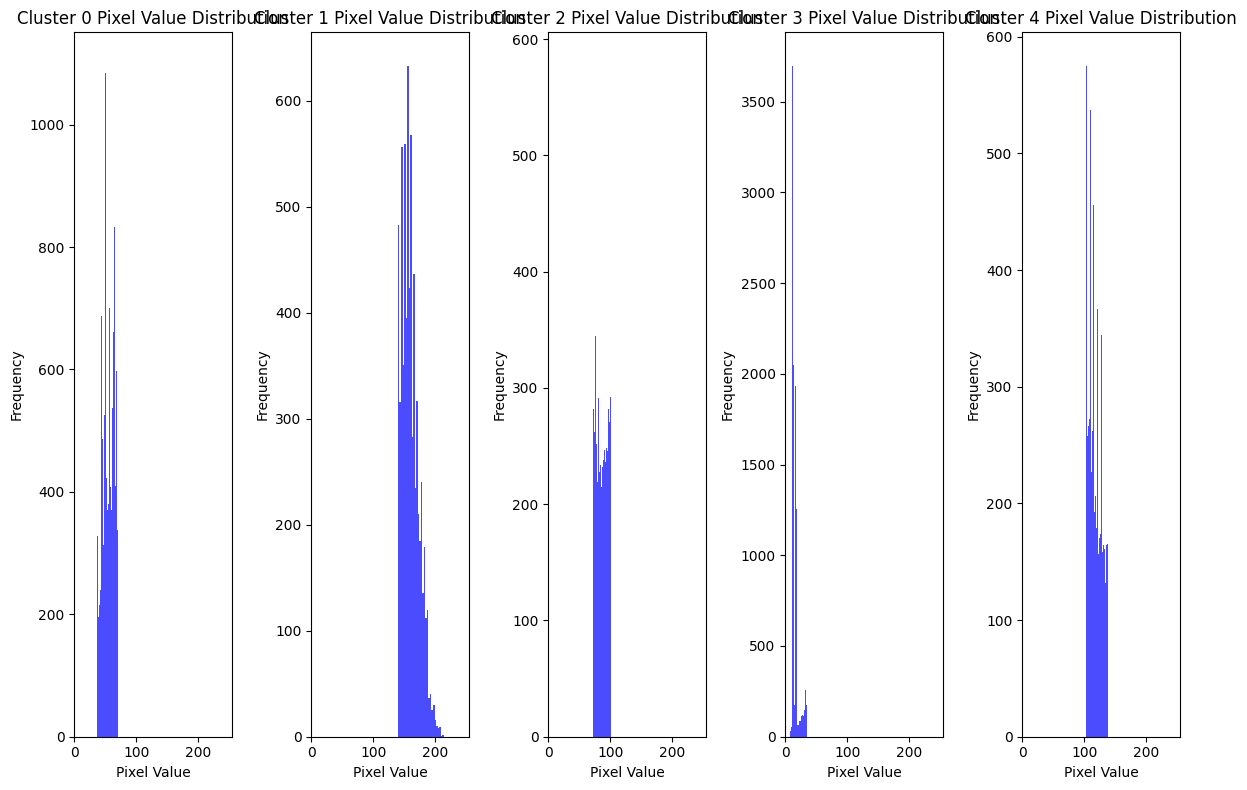

In [10]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False)

# 使用 flow_from_dataframe，設置 batch_size=1
all_images_preprocess = generator.flow_from_dataframe(
    dataframe=images,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  # 將影像大小調整為 224x224
    color_mode='rgb',  # 設置為 RGB
    class_mode=None,  # 不需要類別標籤
    batch_size=1,  # 每次生成一張影像
    shuffle=False,
)

def plot_pixel_value_distribution(image, labels, n_clusters):
    plt.figure(figsize=(12, 8))

    # 為每個聚類繪製直方圖
    for i in range(n_clusters):
        # 提取屬於第 i 個聚類的像素值
        cluster_pixels = image[labels == i]
        print(f"Cluster {i}, {min(cluster_pixels)} ~ {max(cluster_pixels)}")
        
        # 繪製直方圖
        plt.subplot(1, n_clusters, i + 1)
        plt.hist(cluster_pixels, bins=30, color='blue', alpha=0.7)
        plt.title(f'Cluster {i} Pixel Value Distribution')
        plt.xlim([0, 255])
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

image = next(all_images_preprocess)[0]
n_clusters=5
pixel_values = image.reshape((-1, 3))
# pixel_values = image[:,:,0].reshape((-1, 1))

# 轉換成 float32
pixel_values = np.float32(pixel_values)

## 使用 StandardScaler 進行標準化
# =========================
scaler = StandardScaler()
pixel_values_normalized = scaler.fit_transform(pixel_values)
# =========================

# 執行 K-Means 聚類
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(pixel_values_normalized)

## 取得每個像素的標籤
labels = kmeans.labels_
grayscale = all_images[0][:, :, 0].astype(np.uint8)
plot_pixel_value_distribution(grayscale.flatten(), labels, 5)

In [ ]:
# red_channel = image[:, :, 0]   # 提取紅色通道
# green_channel = image[:, :, 1] # 提取綠色通道
# blue_channel = image[:, :, 2]  # 提取藍色通道


# np.array_equal(green_channel, blue_channel)
# np.array_equal(green_channel, red_channel)


# cluster dataset

### 對一張作cluster

In [53]:
# 加载模型
# model = tf.keras.models.load_model('D://reaserch//Bone-Fracture-Detection//weights//中榮//front//transfer_imagenet//a+b_new_data//swift_cut_標準_3_frac.h5')

In [11]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False)
all_images_preprocess = generator.flow_from_dataframe(
    dataframe=images,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  # 將影像大小調整為 224x224
    color_mode='rgb',  # 設置為 RGB
    class_mode=None,  # 不需要類別標籤
    batch_size=32,  # 每次生成一張影像
    shuffle=False,
)

def extract_features(generator, model):
    feature_arr = [] 

    for _ in range(len(generator)):
        image_batch = generator.next()

        feature = model.predict(image_batch)
        feature_arr.append(feature)

    return np.vstack(feature_arr)

# 特徵標準化
features = extract_features(all_images_preprocess, model)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Elbow Method
inertia_values = []
K_range = range(1, 11)  # 設定要測試的 K 值範圍

for k in K_range:
    kmeans2 = KMeans(n_clusters=k, random_state=42)
    kmeans2.fit(features_scaled)
    inertia_values.append(kmeans2.inertia_)  # 獲取慣性值

# 繪製 Elbow 方法的結果
plt.figure(figsize=(5, 3))
plt.plot(K_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid()
plt.show()




Found 834 validated image filenames.


NameError: name 'model' is not defined

In [51]:
# k-means
n_clusters2 = 3

kmeans2 = KMeans(n_clusters=n_clusters2, random_state=42)
kmeans2.fit(features_scaled)

# 結果分析
cluster_labels2 = kmeans2.labels_
image_clusters = pd.DataFrame({'Filepath': images['Filepath'], 'Cluster': cluster_labels2})

# 顯示每個聚類的影像
for cluster in range(n_clusters2):
    cluster_images = image_clusters[image_clusters['Cluster'] == cluster]
    print(f"Cluster {cluster}:")
    # print(cluster_images['Filepath'].values)
    num_three_ankle = np.sum(np.array([1 for file_path in cluster_images['Filepath'].values if '三踝' in file_path]))
    num_double_ankle = np.sum(np.array([1 for file_path in cluster_images['Filepath'].values if '雙踝' in file_path]))
    num_normal = np.sum(np.array([1 for file_path in cluster_images['Filepath'].values if '正常' in file_path]))

    # 總數量
    total_count = len(cluster_images['Filepath'].values)

    # 計算比例
    proportion_three_ankle = num_three_ankle / total_count
    proportion_double_ankle = num_double_ankle / total_count
    proportion_normal = num_normal / total_count

    print(f"三踝的數量: {num_three_ankle}, 比例: {proportion_three_ankle:.2%}")
    print(f"雙踝的數量: {num_double_ankle}, 比例: {proportion_double_ankle:.2%}")
    print(f"正常的數量: {num_normal}, 比例: {proportion_normal:.2%}")
    print()

Cluster 0:
三踝的數量: 51, 比例: 36.43%
雙踝的數量: 83, 比例: 59.29%
正常的數量: 6, 比例: 4.29%

Cluster 1:
三踝的數量: 4, 比例: 2.52%
雙踝的數量: 10, 比例: 6.29%
正常的數量: 145, 比例: 91.19%

Cluster 2:
三踝的數量: 81, 比例: 68.07%
雙踝的數量: 29, 比例: 24.37%
正常的數量: 9, 比例: 7.56%



### 合併後對pixel cluster

In [8]:
# 設置需要顯示的影像數量
num_images_to_show = 5
generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False)

# 使用 flow_from_dataframe，設置 batch_size=1
all_images_preprocess = generator.flow_from_dataframe(
    dataframe=images,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  # 將影像大小調整為 224x224
    color_mode='rgb',        # 設置為 RGB
    class_mode=None,         # 不需要類別標籤
    batch_size=1,            # 每次生成一張影像
    shuffle=False,
)

# 收集所有影像的像素數據以及原始影像
all_pixel_values = []
all_images = []
for _ in range(num_images_to_show):
    image = next(all_images_preprocess)[0]  # 獲取影像
    all_images.append(image)                # 儲存原始影像
    # 展平影像並將像素值添加到列表中
    pixel_values = image.reshape((-1, 3))   # 將影像展平
    all_pixel_values.append(pixel_values)   # 添加到列表中

# 合併所有影像的像素數據
all_pixel_values = np.vstack(all_pixel_values)  # 將所有像素合併成一個大數組
# 對所有像素值進行標準化
scaler = StandardScaler()
all_pixel_values_normalized = scaler.fit_transform(all_pixel_values)


Found 834 validated image filenames.


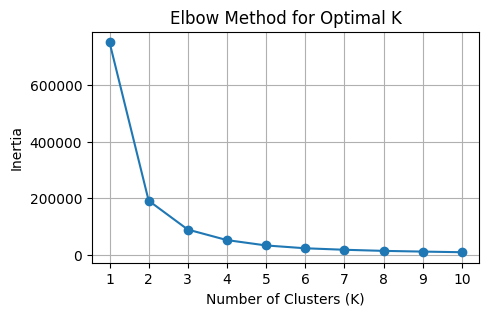

In [53]:
# Elbow Method
inertia_values = []
K_range = range(1, 11)  # 設定要測試的 K 值範圍

for k in K_range:
    kmeans3 = KMeans(n_clusters=k, random_state=42)
    kmeans3.fit(all_pixel_values_normalized)
    inertia_values.append(kmeans3.inertia_)  # 獲取慣性值

# 繪製 Elbow 方法的結果
plt.figure(figsize=(5, 3))
plt.plot(K_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid()
plt.show()

# thresholding

(array([30362.,  3754.,  4410.,  3185.,  2587.,  2750.,  2480.,   559.,
           50.,    39.]),
 array([  4. ,  29.1,  54.2,  79.3, 104.4, 129.5, 154.6, 179.7, 204.8,
        229.9, 255. ]),
 <BarContainer object of 10 artists>)

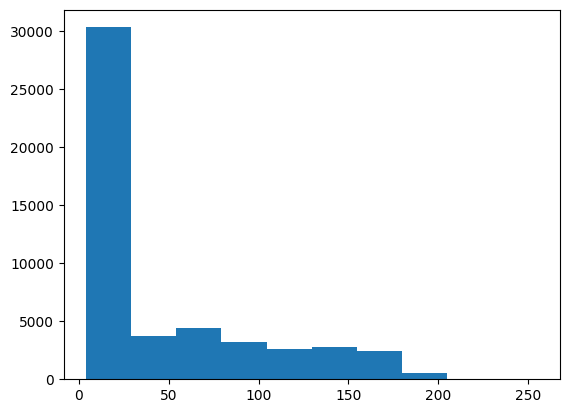

In [73]:
plt.hist(all_images[0].astype('uint8')[:, :, 0].ravel())
# plt.hist(all_images[0].astype('uint8').reshape((-1, 3))[:,0].ravel())


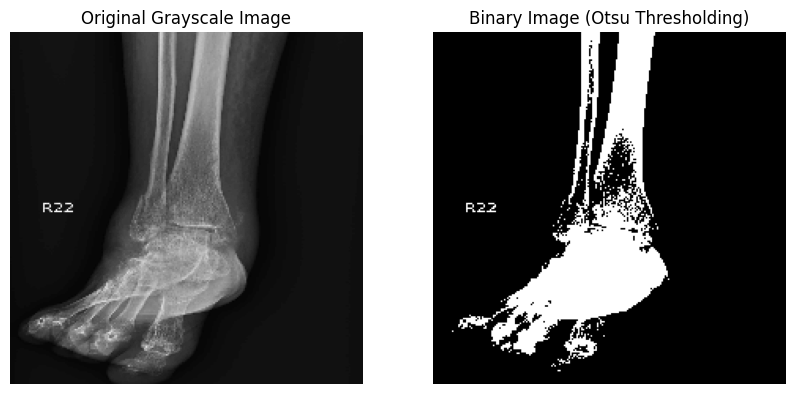

In [111]:
import cv2
grayscale = all_images[0][:, :, 0].astype(np.uint8)

# grayscale = cv2.equalizeHist(grayscale)
grayscale = cv2.GaussianBlur(grayscale, (5, 5), 0)


## threshold 方法
# ==================
## THRESH_OTSU
# threshold_value, binary_image = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

## ADAPTIVE_THRESH_GAUSSIAN_C
# binary_image = cv2.adaptiveThreshold(grayscale, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

## 自定義
threshold = 105
binary_image = np.where(image > threshold, 255, 0).astype(np.uint8)
# ==================

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
image_uint8 = all_images[0][:, :, 0].astype(np.uint8)
plt.imshow(image_uint8, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Threshold image')
plt.axis('off')

plt.show()
